In [1]:
from pathlib import Path
import os

current_dir = Path.cwd()

target_dir = current_dir.parents[1]

os.chdir(target_dir)

print("Working directory changed to:", Path.cwd())

Working directory changed to: /home/hxuan/superposition


In [114]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L", "STIXGeneral"],
    "mathtext.fontset": "stix",   # math matches Times-ish
    "pdf.fonttype": 42,           # keep text as text in PDF
    "ps.fonttype": 42,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
    "figure.constrained_layout.use": True,  # don't also call tight_layout()
})

In [2]:
from src.experiment_superposition import ExperimentSuperposition
from src.utils import CustomLogger, Constants

logger = CustomLogger(level="DEBUG")

exp = ExperimentSuperposition(k=12, d_sweep=[4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 24, 28, 32, 36],
                              pooling="mean", lr=0.1, batch_size=256, model_type="GCN",
                              seeds=[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111], device=Constants.DEVICE, logger=logger)


In [3]:
exp.run_all(use_cached_models=True)

[2025-08-11 13:38:01] [INFO] /home/hxuan/superposition/src/utils.py:45 in run_all() - Initiating experiment 0 with seed 101.
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:80 in run_once() - d=4 acc=0.909 prec=0.622 rec=0.164
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:81 in run_once() - active features: 1
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:80 in run_once() - d=5 acc=0.928 prec=0.765 rec=0.373
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:81 in run_once() - active features: 4
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:80 in run_once() - d=6 acc=0.913 prec=0.615 rec=0.287
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superposition.py:81 in run_once() - active features: 2
[2025-08-11 13:38:02] [INFO] /home/hxuan/superposition/src/experiment_superpo

In [78]:
from collections import defaultdict
import numpy as np

metrics = ["loss", "rec", "n_active", "si", "eff_com", "WNO_a", "WNO_i"]

to_aggregate = defaultdict(lambda: defaultdict(list))

for exp_idx in range(len(exp.seeds)):
    record = exp._load_results(exp_idx)
    for d in exp.d_sweep:
        for m in metrics:
            if m in record[d]:
                to_aggregate[d][m].append(record[d][m])

for d, across_seeds in to_aggregate.items():
    for m in metrics:
        across_seeds[m] = (np.mean(across_seeds[m]), np.std(across_seeds[m]))

for d, aggregated in to_aggregate.items():

    print(f"d={d}")
    for m, (mean, std) in aggregated.items():
        print(f"{m}={mean:.3f}+-{std:.3f}")
    print()

d=4
loss=0.254+-0.019
rec=0.227+-0.079
n_active=2.182+-1.585
si=1.493+-0.139
eff_com=2.280+-0.549
WNO_a=0.900+-0.438
WNO_i=0.466+-0.492

d=5
loss=0.247+-0.025
rec=0.269+-0.118
n_active=3.273+-2.219
si=1.385+-0.177
eff_com=3.020+-1.064
WNO_a=0.977+-0.505
WNO_i=0.499+-0.421

d=6
loss=0.240+-0.029
rec=0.318+-0.115
n_active=3.545+-2.426
si=1.370+-0.182
eff_com=3.475+-1.432
WNO_a=1.136+-0.373
WNO_i=0.562+-0.354

d=7
loss=0.211+-0.026
rec=0.423+-0.116
n_active=5.545+-2.311
si=1.286+-0.101
eff_com=4.370+-1.324
WNO_a=0.833+-0.371
WNO_i=0.433+-0.202

d=8
loss=0.212+-0.016
rec=0.443+-0.066
n_active=5.545+-1.233
si=1.310+-0.071
eff_com=4.277+-1.050
WNO_a=0.914+-0.433
WNO_i=0.329+-0.183

d=9
loss=0.174+-0.039
rec=0.569+-0.136
n_active=7.727+-2.453
si=1.236+-0.083
eff_com=5.926+-1.880
WNO_a=0.709+-0.388
WNO_i=0.366+-0.166

d=10
loss=0.177+-0.033
rec=0.553+-0.129
n_active=7.455+-1.827
si=1.270+-0.045
eff_com=5.909+-1.552
WNO_a=0.844+-0.365
WNO_i=0.349+-0.213

d=11
loss=0.159+-0.039
rec=0.607+-0.126


In [112]:
from typing import Dict, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

def plot_graph_ribbon(
    aggregated: Dict[int, Dict[str, Tuple[float, float]]],
    key: str,
    name: str,
    vline: Optional[float] = 12,
    n: Optional[int] = None,          # number of runs for CI; if None, uses SD
    smooth: bool = False,             # <-- optional smoothing
    smooth_points: int = 400          # resolution of the smoothed curve
):
    # data
    x = np.array(sorted(aggregated.keys()))
    mean = np.array([aggregated[d][key][0] for d in x])
    sd   = np.array([aggregated[d][key][1] for d in x])
    err = (1.96 * sd / np.sqrt(n)) if n else sd

    # default (no smoothing)
    xm, ym, ylo, yhi = x, mean, mean - err, mean + err

    # optional smoothing (monotone cubic); keep markers on real x
    if smooth and len(x) >= 3:
        try:
            from scipy.interpolate import PchipInterpolator
            xs = np.linspace(x.min(), x.max(), smooth_points)
            f  = PchipInterpolator(x, mean)
            flo = PchipInterpolator(x, mean - err)
            fhi = PchipInterpolator(x, mean + err)
            xm, ym, ylo, yhi = xs, f(xs), flo(xs), fhi(xs)
        except Exception:
            pass  # fall back to unsmoothed if scipy not present

    # plot
    plt.figure(figsize=(3.25, 2.1), dpi=300, constrained_layout=True)
    ax = plt.gca()
    ax.plot(xm, ym, linewidth=2)
    ax.fill_between(xm, ylo, yhi, alpha=0.20, linewidth=0)
    ax.plot(x, mean, 'o', markersize=4)  # markers at observed d's

    if vline is not None:
        ax.axvline(vline, color='0.4', linestyle='--', linewidth=1)

    ax.set_xlabel('d')
    ax.set_ylabel(name)
    ax.set_xticks([4, 8, 12, 16, 20, 24, 28, 32, 36])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(width=1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    plt.tight_layout()


/tmp/ipykernel_153348/812372820.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


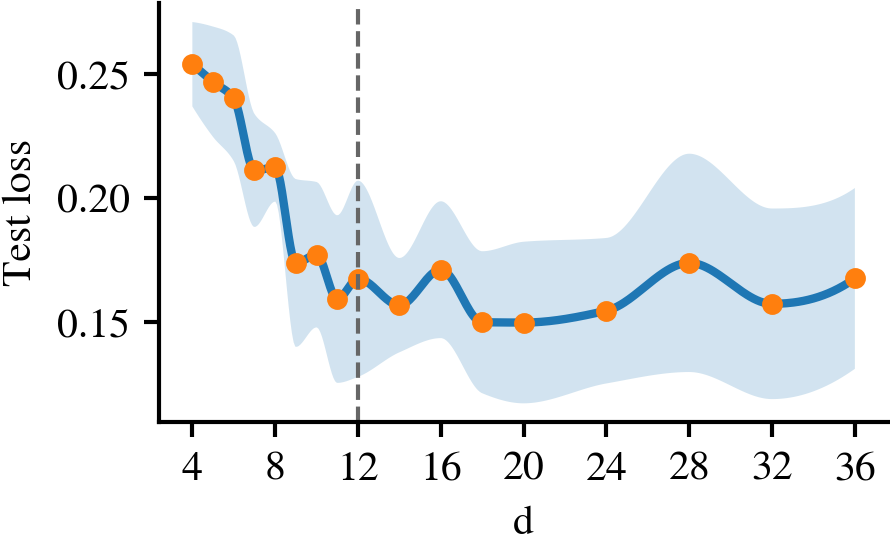

In [115]:
plot_graph_ribbon(to_aggregate, "loss", "Test loss", n=5, smooth=True)
plt.savefig('figures/test.pdf')

/tmp/ipykernel_153348/812372820.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


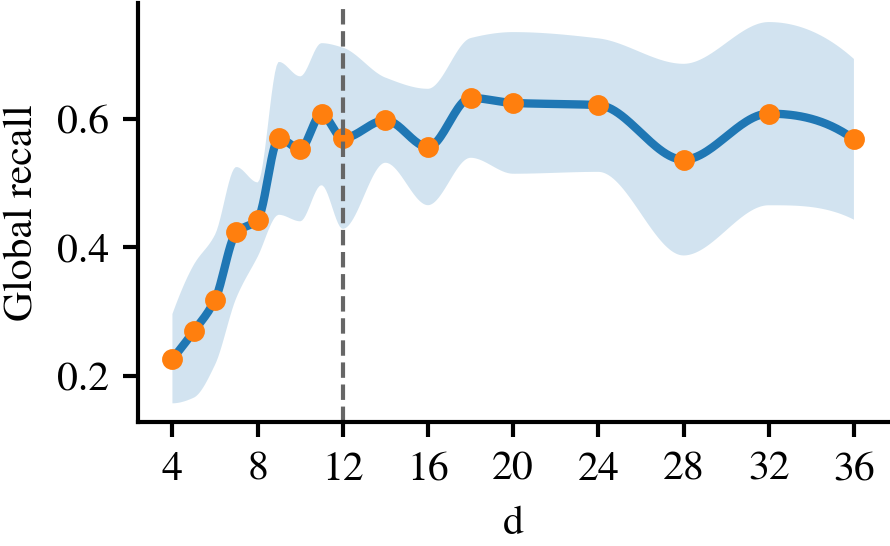

In [116]:
plot_graph_ribbon(to_aggregate, "rec", "Global recall", n=5, smooth=True)
plt.savefig('figures/test.svg')


/tmp/ipykernel_153348/812372820.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


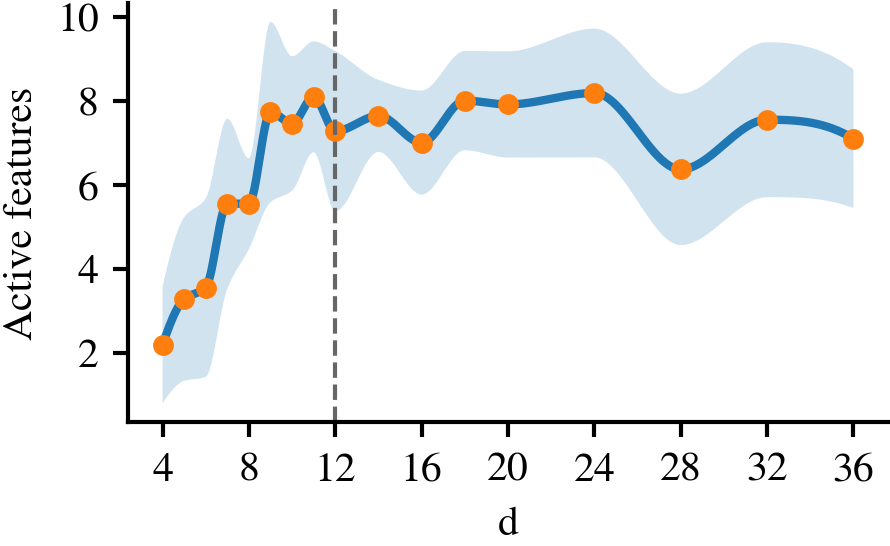

In [117]:
plot_graph_ribbon(to_aggregate, "n_active", "Active features", n=5, smooth=True)
plt.savefig('figures/test.svg')


/tmp/ipykernel_153348/812372820.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


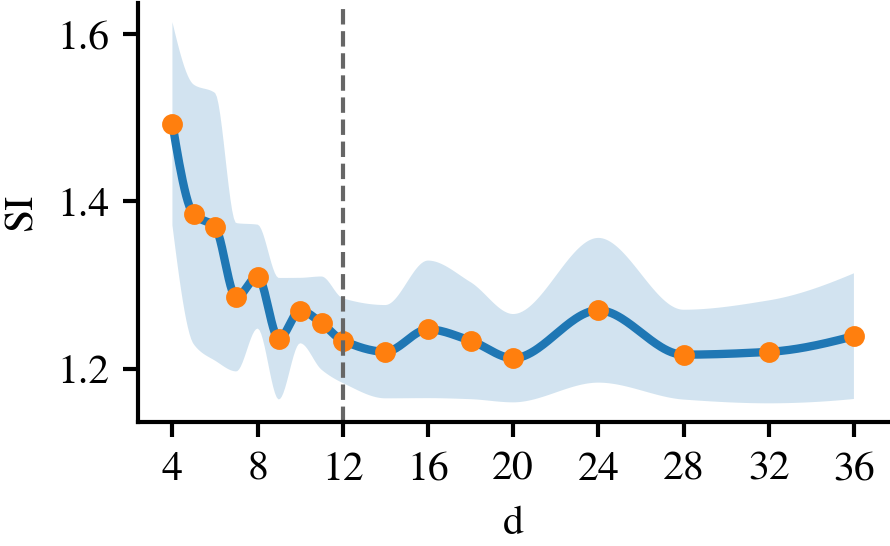

In [120]:
plot_graph_ribbon(to_aggregate, "si", "SI", n=5, smooth=True)
plt.savefig('figures/plot_d_vs_si.pdf')


/tmp/ipykernel_153348/812372820.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


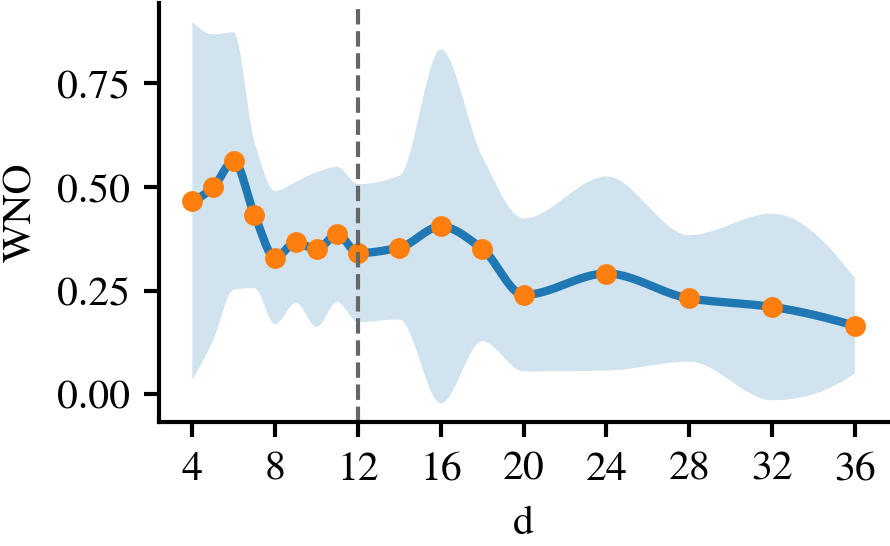

In [121]:
plot_graph_ribbon(to_aggregate, "WNO_i", "WNO", n=5, smooth=True)
plt.savefig('figures/plot_d_vs_WNO.pdf')